# Preprocess

## Init

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from itertools import chain
from hd_utils import monitor
from utils import examine_df
from string import ascii_lowercase
from sklearn.datasets.lfw import Bunch
from raw_preprocessor import RawPreprocessor
from more_itertools import unique_everseen, take
from langdetect import detect as detect_lang, detect_langs

In [4]:
%matplotlib inline
sns.set_style('darkgrid')

In [5]:
args = Bunch()

## Read

In [6]:
_data_base_path = '../code-docstring-corpus/V2/parallel'
args.toplevelfuncs_desc_path = os.path.join(_data_base_path, 'parallel_desc')
args.methods_desc_path = os.path.join(_data_base_path, 'parallel_methods_desc')
args.desc_paths = [args.toplevelfuncs_desc_path, args.methods_desc_path]
args.max_descs = 1000000

In [7]:
def read_desc_gen(file_path):
    with open(file_path, 'r', errors='ignore') as f:
        for line in f:
            yield line.strip()[1:-1].strip()
            
            
def read_all_descs():
    all_gen = (read_desc_gen(desc_path) for desc_path in args.desc_paths)
    return list(take(args.max_descs, unique_everseen(chain.from_iterable(all_gen))))

In [8]:
%time descs = read_all_descs()
print(len(descs))
descs[0]

CPU times: user 768 ms, sys: 64 ms, total: 832 ms
Wall time: 834 ms
357220


'load a Python source file and compile it to byte-code DCNL _load_module(filename: string): code_object DCNL filename:   name of file containing Python source code DCNL (normally a .py) DCNL code_object: code_object compiled from this source code DCNL This function does NOT write any file!'

## Preprocessing

In [9]:
args.log_step = 5000

In [10]:
raw = [{'text': desc} for desc in descs]
raw[0]

{'text': 'load a Python source file and compile it to byte-code DCNL _load_module(filename: string): code_object DCNL filename:   name of file containing Python source code DCNL (normally a .py) DCNL code_object: code_object compiled from this source code DCNL This function does NOT write any file!'}

In [11]:
preprocessor = RawPreprocessor(
    monitor=monitor('[1.1.1] Docstring preprocessing', log_step=args.log_step),
    do_tqdm=True
)
df = preprocessor.fit_transform(raw)
examine_df(df)

100%|██████████| 357220/357220 [3:42:40<00:00, 26.74it/s]  


shape=(315806, 2)


text    tags
head 0       load a Python source file and compile it to by...     NaN
     1       load a module without importing it DCNL _load_...     NaN
     2                  decompile Python byte-code file (.pyc)     NaN
     3       in_base     base directory for input files DCN...     NaN
tail 315802  Handle ``grant_type=password`` requests as def...     NaN
     315803  Return a function or method that is capable ha...     NaN
     315804  As per :rfc:`3.2` the token endpoint *only* su...     NaN
     315805  As per :rfc:`3.2` the token endpoint *only* su...     NaN
meta type                                               object  object
math count                                              315806  315806
     unique                                             315806       1
     top     Sets invalidation python dict as JSON invalida...     NaN
     freq                                                    1  315806

## Sanity check

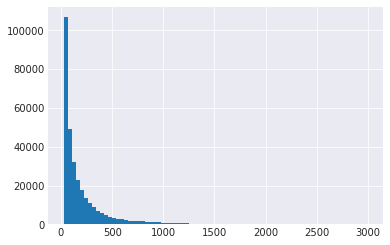

In [12]:
df.text.map(len).hist(bins=75);

In [13]:
df.text.sample(10).tolist()

['Returns the IP address of the vCenter host.',
 "Handles whenever a block\\'s score is published. DCNL Returns whether the score was actually updated.",
 'Whether Human Resources should use Certificates',
 ':return: True if the remote user can add entries to his crontab',
 'Compute the unitary, ordinary-frequency inverse sine transform of `F`, DCNL defined as DCNL .. math:: f(x) = \\sqrt{\\frac{2}{\\pi}} \\int_{0}^\\infty F(k) \\sin(2\\pi x k) \\mathrm{d} k. DCNL If the transform cannot be computed in closed form, this DCNL function returns an unevaluated :class:`InverseSineTransform` object. DCNL For a description of possible hints, refer to the docstring of DCNL :func:`sympy.integrals.transforms.IntegralTransform.doit`. DCNL Note that for this transform, by default ``noconds=True``. DCNL >>> from sympy import inverse_sine_transform, exp, sqrt, gamma, pi DCNL >>> from sympy.abc import x, k, a DCNL >>> inverse_sine_transform(2**((1-2*a)/2)*k**(a - 1)* DCNL ...     gamma(-a/2 + 1)/gamm

## Save

In [14]:
args.save_path = 'docstring_data.hdf5'

In [15]:
%time df.to_hdf(args.save_path, 'df', mode='w', format='f', complevel=9)

CPU times: user 280 ms, sys: 172 ms, total: 452 ms
Wall time: 1.03 s


In [16]:
!du -sh $args.save_path

69M	docstring_data.hdf5


## End

In [17]:
args

{'desc_paths': ['../code-docstring-corpus/V2/parallel/parallel_desc',
  '../code-docstring-corpus/V2/parallel/parallel_methods_desc'],
 'log_step': 5000,
 'max_descs': 1000000,
 'methods_desc_path': '../code-docstring-corpus/V2/parallel/parallel_methods_desc',
 'save_path': 'docstring_data.hdf5',
 'toplevelfuncs_desc_path': '../code-docstring-corpus/V2/parallel/parallel_desc'}